In [ ]:
import re

import numpy as np 
import pandas as pd 

import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout
from sklearn.model_selection import train_test_split

In [ ]:
import os
from google.colab import drive
MOUNTPOINT = '/content/gdrive'
DATADIR = os.path.join(MOUNTPOINT, 'My Drive')
drive.mount(MOUNTPOINT)



Mounted at /content/gdrive


In [ ]:
import cv2
import numpy as np


# https://drive.google.com/open?id=1W_moLzMlGiELyPxWiYQJ9KFaXroQ_NFQ
GENDER_MODEL = '/content/gdrive/My Drive/dataset/deploy_gender.prototxt'

# https://drive.google.com/open?id=1AW3WduLk1haTVAxHOkVS_BEzel1WXQHP
GENDER_PROTO = '/content/gdrive/My Drive/dataset/gender_net.caffemodel'

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)

GENDER_LIST = ['Male', 'Female']
# https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
FACE_PROTO = "/content/gdrive/My Drive/dataset/deploy.prototxt.txt"
# https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20180205_fp16/res10_300x300_ssd_iter_140000_fp16.caffemodel
FACE_MODEL = "/content/gdrive/My Drive/dataset/res10_300x300_ssd_iter_140000_fp16.caffemodel"

In [ ]:
face_net = cv2.dnn.readNetFromCaffe(FACE_PROTO, FACE_MODEL)
# Load gender prediction model
gender_net = cv2.dnn.readNetFromCaffe(GENDER_MODEL, GENDER_PROTO)

In [ ]:
def get_faces(frame, confidence_threshold=0.5):

    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), (104, 177.0, 123.0))
    
    face_net.setInput(blob)

    output = np.squeeze(face_net.forward())
   
    faces = []
   
    for i in range(output.shape[0]):
        confidence = output[i, 2]
        if confidence > confidence_threshold:
            box = output[i, 3:7] * \
                np.array([frame.shape[1], frame.shape[0],
                         frame.shape[1], frame.shape[0]])
         
            start_x, start_y, end_x, end_y = box.astype(np.int)
            
            start_x, start_y, end_x, end_y = start_x - \
                10, start_y - 10, end_x + 10, end_y + 10
            start_x = 0 if start_x < 0 else start_x
            start_y = 0 if start_y < 0 else start_y
            end_x = 0 if end_x < 0 else end_x
            end_y = 0 if end_y < 0 else end_y
            
            faces.append((start_x, start_y, end_x, end_y))
    return faces

In [ ]:
def display_img(title, img):
    """Displays an image on screen and maintains the output until the user presses a key"""
    
    cv2_imshow(img)                
    
    cv2.waitKey(0)
    
    cv2.destroyAllWindows()

In [ ]:
def get_optimal_font_scale(text, width):
    """Determine the optimal font scale based on the hosting frame width"""
    for scale in reversed(range(0, 60, 1)):
        textSize = cv2.getTextSize(text, fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=scale/10, thickness=1)
        new_width = textSize[0][0]
        if (new_width <= width):
            return scale/10
    return 1


def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):

    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
 
    if width is None:
        
        r = height / float(h)
        dim = (int(w * r), height)
  
    else:
        
        r = width / float(w)
        dim = (width, int(h * r))
    
    return cv2.resize(image, dim, interpolation = inter)

In [ ]:
from google.colab.patches import cv2_imshow
def predict_gender(input_path: str):
    """Predict the gender of the faces showing in the image"""
    
    img =cv2.imread(input_path)
    
    
  
    frame = img.copy()
    
    faces = get_faces(frame)
    
    for i, (start_x, start_y, end_x, end_y) in enumerate(faces):
        face_img = frame[start_y: end_y, start_x: end_x]
      
        blob = cv2.dnn.blobFromImage(image=face_img, scalefactor=1.0, size=(
            227, 227), mean=MODEL_MEAN_VALUES, swapRB=False, crop=False)
        # Predict Gender
        gender_net.setInput(blob)
        gender_preds = gender_net.forward()
        i = gender_preds[0].argmax()
        gender = GENDER_LIST[i]
        gender_confidence_score = gender_preds[0][i]
        # Draw the box
        label = "{}-{:.2f}%".format(gender, gender_confidence_score*100)
        print(label)
        yPos = start_y - 15
        while yPos < 15:
            yPos += 15
        # get the font scale for this image size
        optimal_font_scale = get_optimal_font_scale(label,((end_x-start_x)+25))
        box_color = (255, 0, 0) if gender == "Male" else (147, 20, 255)
        cv2.rectangle(frame, (start_x, start_y), (end_x, end_y), box_color, 2)
        # Label processed image
        cv2.putText(frame, label, (start_x, yPos),
                    cv2.FONT_HERSHEY_SIMPLEX, optimal_font_scale, box_color, 2)

        # Display processed image
    display_img("Gender Estimator", frame)
  
    cv2.destroyAllWindows()

Male-100.00%


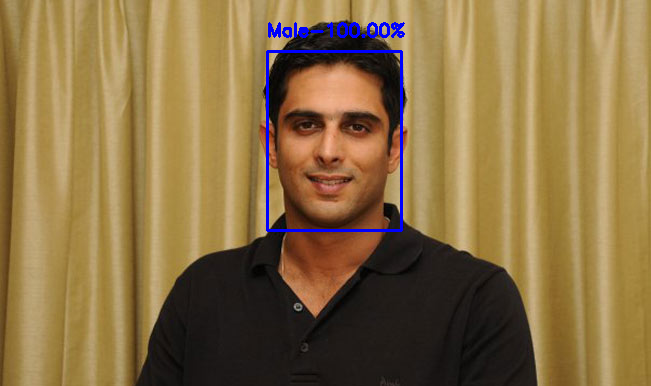

Male-100.00%


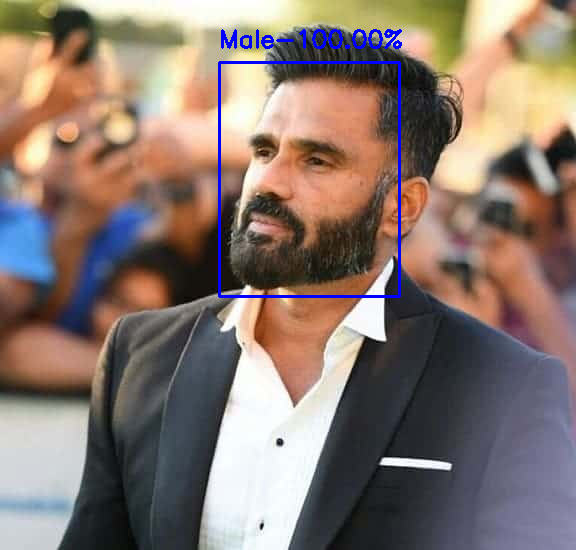

Male-100.00%


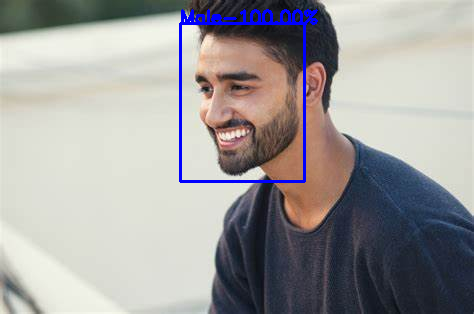

Female-81.54%


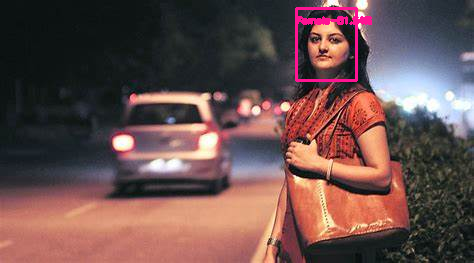

Female-80.86%


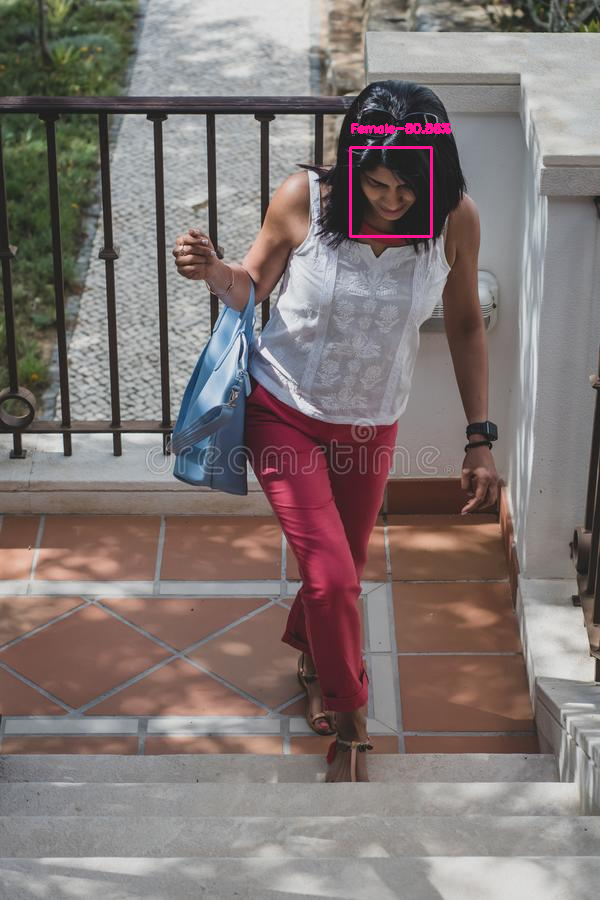

Female-99.97%
Female-93.16%
Female-96.68%


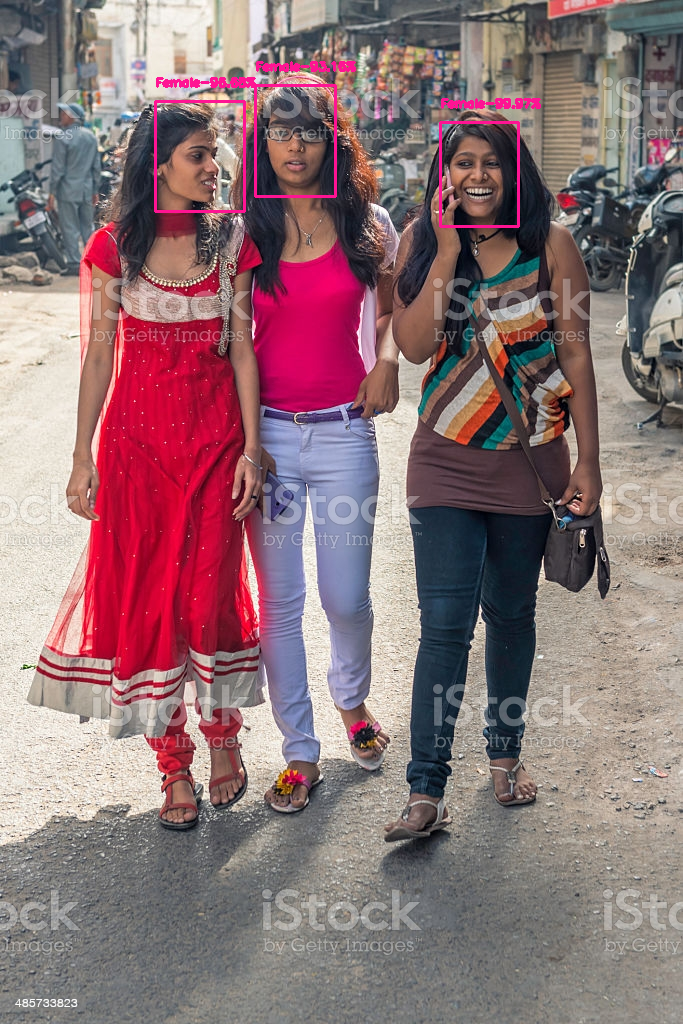

In [ ]:

predict_gender('/content/gdrive/My Drive/dataset/male1.jpg')
predict_gender('/content/gdrive/My Drive/dataset/male2.jpg')
predict_gender('/content/gdrive/My Drive/dataset/male3.jpg')
predict_gender('/content/gdrive/My Drive/dataset/femal1.jpg')
predict_gender('/content/gdrive/My Drive/dataset/female2.jpg')
predict_gender('/content/gdrive/My Drive/dataset/female3.jpg')